## Fine-Tune BERT on Sentiment Analysis (Hugging Face)

### Make Exploratory Data Analysis (EDA) on the loaded dataset

In [84]:
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords

# Download the NLTK stopwords corpus if not already present
nltk.download("stopwords")

# Create a set of English stopwords for later use
stop_words = set(stopwords.words("english"))

# 1. Load dataset (e.g., IMDb movie reviews)
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42)  # Reduce size for demo

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/developer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from datasets import load_dataset
import pandas as pd

# 1. Load IMDb Dataset
dataset = load_dataset("imdb")

# Explore the dataset before splitting
print(dataset)

# Access the splits
train_data = pd.DataFrame(dataset["train"]) # type: ignore
test_data = pd.DataFrame(dataset["test"]) # type: ignore
unsupervised_data = pd.DataFrame(dataset["unsupervised"]) # type: ignore

print("Train shape:", train_data.shape)  # Include: train and validation
print("Test shape:", test_data.shape)
print("Unsupervised shape", unsupervised_data.shape)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Train shape: (25000, 2)
Test shape: (25000, 2)
Unsupervised shape (50000, 2)


In [106]:
# 2. Basic Info
print("📊 Dataset Shape:", train_data.shape)
print("📝 Sample Data:\n", train_data.sample(5))
print("🧾 Class Distribution:\n", train_data["label"].value_counts())

📊 Dataset Shape: (25000, 2)
📝 Sample Data:
                                                     text  label
9468   This film limps from self indulgent moment to ...      0
21185  The Sentinel i was hoping would be a good film...      1
8495   What's written on the poster is: "At birth he ...      0
23582  I too have gone thru very painful personal los...      1
21194  Engaging, riveting tale of captured US army tu...      1
🧾 Class Distribution:
 label
0    12500
1    12500
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

all_data = pd.concat(
    [
        pd.DataFrame(dataset["train"]), # type: ignore
        pd.DataFrame(dataset["test"]), # type: ignore
    ],
    ignore_index=True,
)

# Split all_data into train + test (65/35)
train_df, test_df = train_test_split(
    all_data, test_size=0.35, stratify=all_data["label"], random_state=42
)

print("Train set:", train_df.shape)
print("Test set:", test_df.shape)

Train set: (32500, 2)
Validation set: (17500, 2)


In [ ]:
print(train_df.head())
print(test_df.head())

                                                    text  label
14203  SPOILERS Sex huh? It's one of the most basic p...      1
6887   What a complete piece of trash. Plot notwithst...      0
9634   The over-heated plot of "Bonjour tristesse" is...      0
17672  As a lover of bad movies, I definitely hit pay...      1
6578   Designed only to annoy (or amuse) any self-res...      0
                                                    text  label
14895  I instantly fell in love with "Pushing Daisies...      1
9308   this movie is, despite its "independent" statu...      0
15192  Silverlake Life, The view from here, is an abs...      1
22549  I avoided watching this film for the longest t...      1
8987   Channel surfing and caught this on LOGO. It wa...      0


In [ ]:
# 3. Rename label for clarity
train_df["label"] = train_df["label"].map({0: "negative", 1: "positive"})
test_df["label"] = test_df["label"].map({0: "negative", 1: "positive"})

In [ ]:
print(train_df.head())
print(test_df.head())

                                                    text     label
14203  SPOILERS Sex huh? It's one of the most basic p...  positive
6887   What a complete piece of trash. Plot notwithst...  negative
9634   The over-heated plot of "Bonjour tristesse" is...  negative
17672  As a lover of bad movies, I definitely hit pay...  positive
6578   Designed only to annoy (or amuse) any self-res...  negative
                                                    text     label
14895  I instantly fell in love with "Pushing Daisies...  positive
9308   this movie is, despite its "independent" statu...  negative
15192  Silverlake Life, The view from here, is an abs...  positive
22549  I avoided watching this film for the longest t...  positive
8987   Channel surfing and caught this on LOGO. It wa...  negative


In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16250 entries, 14203 to 14566
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16250 non-null  object
 1   label   16250 non-null  object
dtypes: object(2)
memory usage: 380.9+ KB


/tmp/ipykernel_122908/1742132709.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="label", palette="Set2")


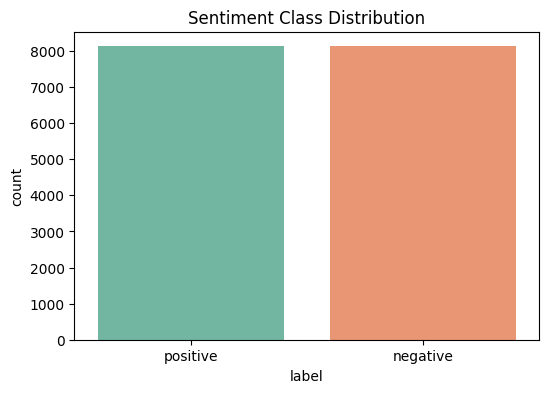

In [102]:
# 4. Visualize Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x="label", palette="Set2")
plt.title("Sentiment Class Distribution")
plt.show()

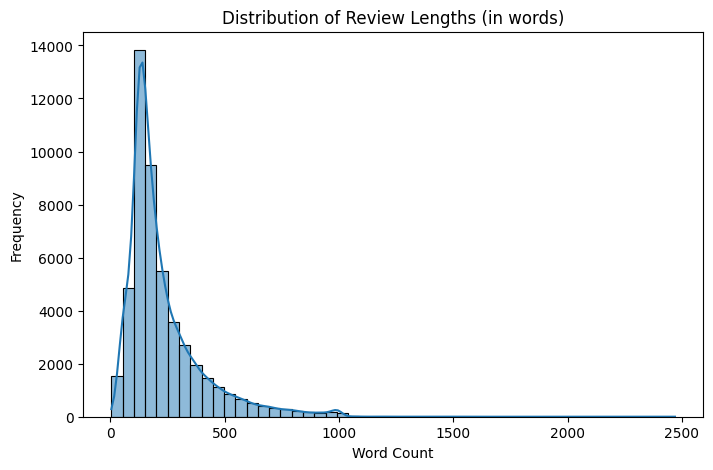

In [115]:
# 5. Text Length Analysis
all_data["text_length"] = all_data["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=all_data, x="text_length", bins=50, kde=True)
plt.title("Distribution of Review Lengths (in words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

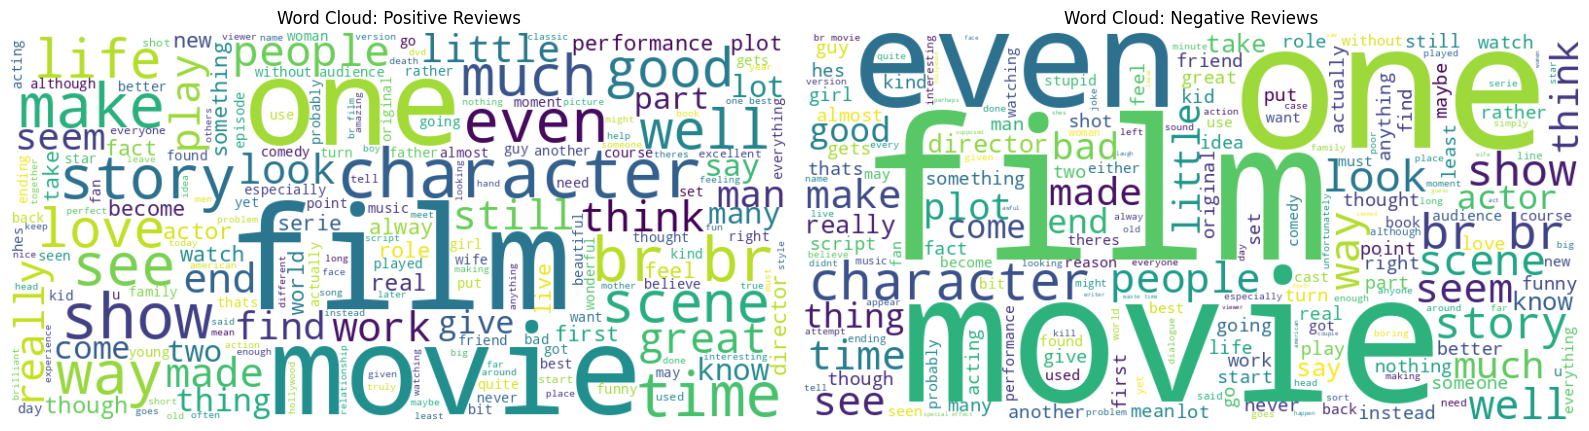

In [119]:
from wordcloud import WordCloud
import string


# 6. WordClouds for Positive and Negative Reviews

def preprocess_text(text):
    """
    Preprocess the input text by:
    - Lowercasing all characters
    - Removing punctuation
    - Removing stopwords and non-alphabetic tokens
    Returns a cleaned string.
    """
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    words = text.split()  # Split text into words
    # Remove stopwords and non-alphabetic tokens, then join back to string
    return " ".join([word for word in words if word not in stop_words and word.isalpha()])

# Concatenate all positive review texts after preprocessing
positive_text = " ".join(
    all_data[all_data["label"] == 1]["text"].apply(preprocess_text)
)

# Concatenate all negative review texts after preprocessing
negative_text = " ".join(
    all_data[all_data["label"] == 0]["text"].apply(preprocess_text)
)

# Plot word clouds for positive and negative reviews
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with 2 subplots

# Generate and plot word cloud for positive reviews
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
axs[0].imshow(wordcloud_pos, interpolation="bilinear")  # Display the word cloud image
axs[0].axis("off")  # Hide axes
axs[0].set_title("Word Cloud: Positive Reviews")  # Set subplot title

# Generate and plot word cloud for negative reviews
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_text)
axs[1].imshow(wordcloud_neg, interpolation="bilinear")  # Display the word cloud image
axs[1].axis("off")  # Hide axes
axs[1].set_title("Word Cloud: Negative Reviews")  # Set subplot title

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()  # Display the plots


### (Optional) Step-by-Step: IMDb Train / Validation / Test Split

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the IMDb dataset from Hugging Face
dataset = load_dataset("imdb")

# Convert 'train' and 'test' splits to DataFrames
df_train_full = pd.DataFrame(dataset["train"])  # type: ignore # 25,000 samples
df_test = pd.DataFrame(dataset["test"])  # type: ignore # 25,000 samples

In [121]:
from sklearn.model_selection import train_test_split

# Split train into train (80%) and validation (20%)
df_train, df_val = train_test_split(
    df_train_full,
    test_size=0.2,
    stratify=df_train_full["label"],  # keep label distribution balanced
    random_state=42,
)

# Show shapes
print("✅ Final Splits:")
print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

✅ Final Splits:
Train: (20000, 2)
Validation: (5000, 2)
Test: (25000, 2)


### Tokenize the dataset

In [122]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [123]:
# 3. Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


encoded_dataset = dataset.map(tokenize, batched=True)
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 50000/50000 [01:37<00:00, 511.53 examples/s]


In [ ]:
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [130]:
# Fix imports for Trainer and TrainingArguments
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments

# 4. Define training arguments (remove unsupported parameters)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
)

# 5. Trainer API
# Use slicing instead of .select if select is not available
train_dataset = encoded_dataset["train"][:4000]
eval_dataset = encoded_dataset["train"][4000:5000]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# 6. Train (fine-tune) the model
trainer.train()

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset

# 1. Load dataset (e.g., IMDb movie reviews)
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42).select(range(5000))  # Reduce size for demo

# 2. Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")


# 3. Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


encoded_dataset = dataset.map(tokenize, batched=True)
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 4. Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
)

# 5. Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"].select(range(4000)),
    eval_dataset=encoded_dataset["train"].select(range(4000, 5000)),
)

# 6. Train (fine-tune) the model
trainer.train()